In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

import tensorflow as tf


from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import initializers


from tensorflow.keras.datasets import mnist

# Other examples

# Fashion-MNIST: tensorflow.keras.datasets.fashion_mnist, 60k 28x28 grayscale images of 10 fashion categories, along with a test set of 10k images
# -------------

####################### TODO ########################
# Homework: Repeat the generation on CIFAR10 database

# CIFAR: tensorflow.keras.datasets.cifar10 ,  50k 32x32 color training images and 10k test images, labeled over 10 categories
# ----- Homework!! -----


In [ ]:
# Load MNIST data
# ---------------
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5)/127.5     # <-- Dataset Normalization [-1:1]

X_train = X_train[:, :, :, np.newaxis]
X_test  = X_test[:, :, :, np.newaxis]


print("Training Shape: ",np.shape(X_train))



Training Shape:  (60000, 28, 28, 1)


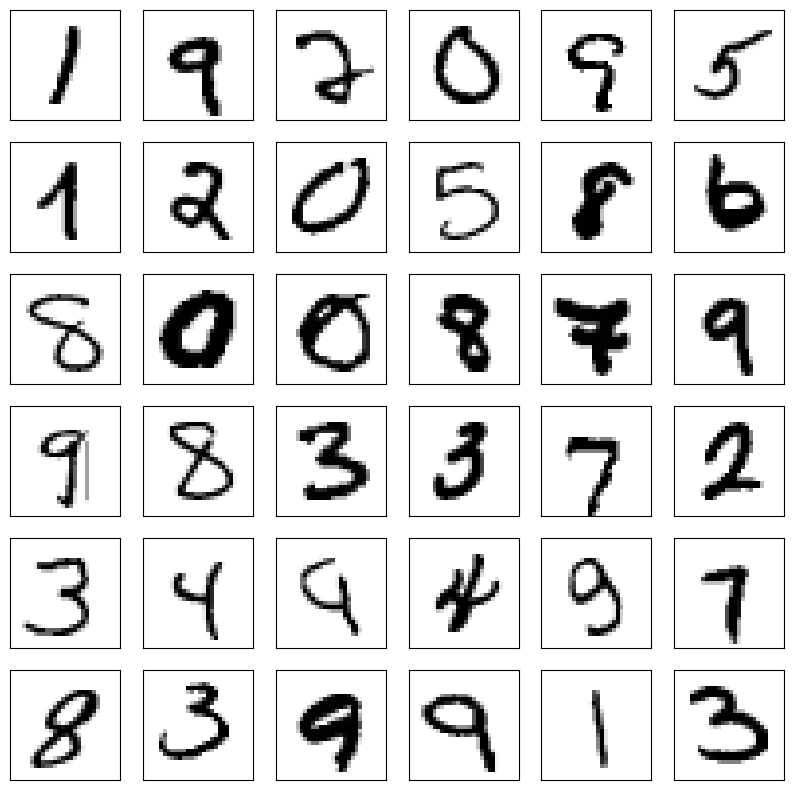

In [ ]:
def plotRealImages():
    plt.figure(figsize=(10,10))
    random_inds = np.random.choice(60000,36)
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_ind = random_inds[i]
        plt.imshow(np.squeeze(X_train[image_ind]), cmap=plt.cm.binary)
        #plt.xlabel(y_train[image_ind])

plotRealImages()

In [ ]:
# Deterministic output.
# Tired of seeing the same results every time? Comment the line below.
np.random.seed(1000)


# Dimension of THE LATENT VARIABLE VECTOR (I choose 10 you can try other values!! Expecially with CIFAR10 database !!)
randomDim = 10

In [ ]:
# Generator
# ---------
def build_generator():

    generator = Sequential()

    # Input is z -> latent vector of 10 elements

    # Fully connected Layer --> FIRST HIDDEN LAYER
    generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    # Reshape from a vector of 6272 to 128 matrixes 7x7
    generator.add(Reshape((7, 7, 128)))

    # Convolutional Layer (64-filters 5x5) --> SECOND HIDDEN LAYER (#weigths are 64 x (5x5) x 128 + 64 thresholds)
    generator.add(Conv2DTranspose(64, (5,5), strides=2, padding='same'))
    generator.add(LeakyReLU(0.2))

    # Convolutional Layer (1-filter 5x5) <-- OUTPUT LAYER (#weigths TODO!!)
    generator.add(Conv2DTranspose(1, (5,5), strides=2, padding='same', activation='tanh'))
    generator.summary()

    return generator


In [ ]:
# Discriminator
# -------------
def build_discriminator():

    discriminator = Sequential()

    # TRY TO FIGURE OUT THE NUMBER OF HIDDEN LAYER AND THE STRUCTURE OF THIS NETWORK
    # you can use info from the summary!!

    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.summary()

    return discriminator



In [ ]:

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Build and compile the generator
generator = build_generator()

generator.compile(loss='binary_crossentropy', optimizer=adam)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              68992     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 1)        1601      
 ranspose)                                            

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

# Build and compile the discriminator
# -----------------------------------
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [ ]:
# Combined network (GAN)
# ----------------------

discriminator.trainable = False # <-- Notice: All Discriminator' weights will be trained separately
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)

# AGAIN We need to COMPILE The COMBINED GAN MODEL
# -----------------------------------------------
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         275457    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


In [ ]:
# Plot the loss from each batch
# -----------------------------
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    #plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)


# Create a wall of generated MNIST images
# ---------------------------------------
def plotGeneratedImages(epoch=0, examples=36, dim=(6, 6), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, :,:, 0], interpolation='nearest', cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        #plt.axis('off')
    plt.tight_layout()
    plt.show()
    #plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)


# Save the generator and discriminator networks (and weights) for later use
# -------------------------------------------------------------------------
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)



2/2 [==============================] - 9s 49ms/step


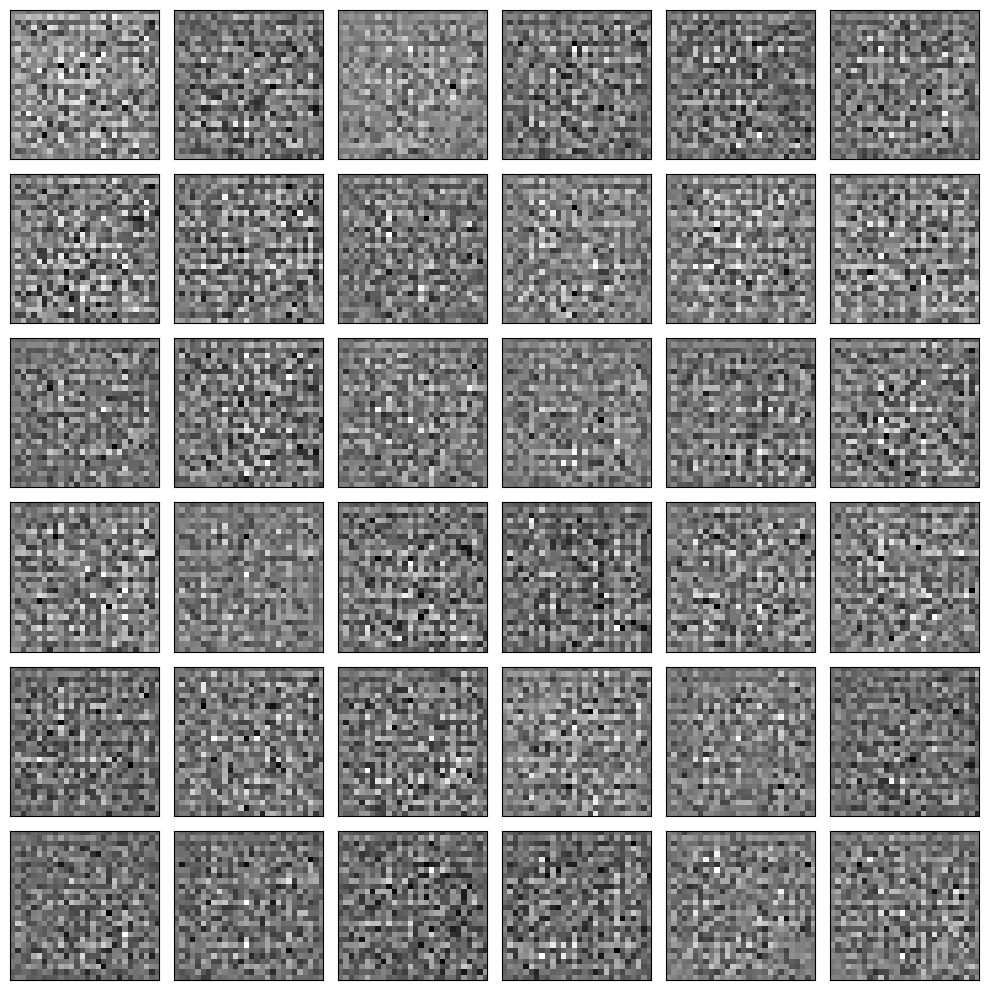

In [ ]:
plotGeneratedImages()

In [ ]:
# Initialize losses as empty arrays
dLosses = []
gLosses = []


def train(epochs=1, batchSize=128, outputfreq=1):

    # Epochs: indicates the number of passes of the ENTIRE training dataset the GAN algorithm has completed.
    # Mini-batch: means you only take a subset of all your data to compute the gradient during one iteration.


    # Calculate the number of Mini-batches per epoch
    batchCount = X_train.shape[0] // batchSize

    print('\nEpochs:', epochs)
    print('mini-Batch size:', batchSize)
    print('mini-Batches per epoch:', batchCount)

    # In our case we expect, mini-Batch per epoch: floor(468.75) -> 468

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15) # print on screen a new epoch
        time.sleep(0.5) # (Needs only slow down and clean the output on screen)
        for _ in tqdm(range(batchCount)):


            # We First Train the Discriminator (max_D)
            # --------------------------------

            # Collect from Training Dataset a Mini-batch of REAL imagaes
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)] # !!REAL IMAGES!!

            # Generate fake MNIST images
            # --------------------------

            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim]) # !!LATENT VECTOR!!
            generatedImages = generator.predict(noise) # !!FAKE IMAGES!!

            # Concatenate real and generated images
            # -------------------------------------
            X = np.concatenate([imageBatch, generatedImages])

            # Build Labels for generated and real data
            # ----------------------------------------
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9  # Trick to help Generator

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis) # !!1) ACTUAL TRAINING FOR THE DISCRIMINATOR!!


            # Second We Train the Generator (max_G)
            # -------------------------------------

            # Train the generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim]) # !!NEW LATENT VECTOR!!
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen) # !!2) ACTUAL TRAINING FOR THE GENERATOR!!

            # -----------------------
            # ENDs LOOP ON MINI-BATCH

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        #if (e == 1) or (e % outputfreq) == 0:
           #plotGeneratedImages(e)
           #saveModels(e) # AVAILABLE ON YOUR LAPTOPs

        # -------------------
        # ENDs LOOP ON EPOCHs



    # Plot losses from every epoch
    plotLoss(e)



Epochs: 2
mini-Batch size: 128
mini-Batches per epoch: 468
--------------- Epoch 1 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


  0%|          | 1/468 [00:01<10:01,  1.29s/it]

4/4 [==============================] - 0s 3ms/step


  0%|          | 2/468 [00:01<04:35,  1.69it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 3/468 [00:01<03:00,  2.58it/s]

4/4 [==============================] - 0s 4ms/step


  1%|          | 4/468 [00:01<02:10,  3.55it/s]

4/4 [==============================] - 0s 3ms/step


  1%|▏         | 6/468 [00:01<01:23,  5.50it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 8/468 [00:02<01:06,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


  2%|▏         | 10/468 [00:02<00:57,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 12/468 [00:02<00:52,  8.66it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 14/468 [00:02<00:49,  9.22it/s]

4/4 [==============================] - 0s 2ms/step


  3%|▎         | 16/468 [00:02<00:45,  9.84it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 18/468 [00:02<00:45,  9.86it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 20/468 [00:03<00:44,  9.97it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▍         | 22/468 [00:03<00:45,  9.73it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 23/468 [00:03<00:47,  9.36it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 24/468 [00:03<00:47,  9.27it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 25/468 [00:03<00:47,  9.29it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 26/468 [00:03<00:48,  9.19it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 27/468 [00:04<00:56,  7.78it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 28/468 [00:04<01:02,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 29/468 [00:04<01:02,  7.01it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▋         | 30/468 [00:04<01:08,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 31/468 [00:04<01:12,  5.99it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 32/468 [00:04<01:09,  6.30it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 33/468 [00:05<01:06,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 34/468 [00:05<01:11,  6.10it/s]

4/4 [==============================] - 0s 5ms/step


  7%|▋         | 35/468 [00:05<01:12,  5.97it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 36/468 [00:05<01:11,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 37/468 [00:05<01:16,  5.67it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 38/468 [00:05<01:16,  5.66it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 39/468 [00:06<01:17,  5.54it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▊         | 40/468 [00:06<01:09,  6.15it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 41/468 [00:06<01:03,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 42/468 [00:06<00:59,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 43/468 [00:06<00:55,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 44/468 [00:06<00:54,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 45/468 [00:06<00:52,  8.13it/s]

4/4 [==============================] - 0s 3ms/step


 10%|▉         | 46/468 [00:06<00:51,  8.23it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 47/468 [00:07<00:50,  8.36it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 48/468 [00:07<00:48,  8.66it/s]

4/4 [==============================] - 0s 2ms/step


 10%|█         | 49/468 [00:07<00:46,  8.95it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 50/468 [00:07<00:47,  8.86it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 51/468 [00:07<00:46,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 52/468 [00:07<00:48,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█▏        | 53/468 [00:07<00:48,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 54/468 [00:07<00:47,  8.71it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 55/468 [00:07<00:48,  8.48it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 56/468 [00:08<00:48,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 57/468 [00:08<00:47,  8.68it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 58/468 [00:08<00:47,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 59/468 [00:08<00:47,  8.65it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 60/468 [00:08<00:46,  8.68it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 61/468 [00:08<00:48,  8.45it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 62/468 [00:08<00:49,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 63/468 [00:08<00:52,  7.65it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▎        | 64/468 [00:09<00:51,  7.80it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 65/468 [00:09<00:49,  8.06it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 66/468 [00:09<00:49,  8.19it/s]

4/4 [==============================] - 0s 3ms/step


 14%|█▍        | 67/468 [00:09<00:48,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 68/468 [00:09<00:52,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 69/468 [00:09<00:52,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 70/468 [00:09<00:51,  7.76it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▌        | 71/468 [00:09<00:49,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▌        | 72/468 [00:10<00:47,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 73/468 [00:10<00:46,  8.55it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 74/468 [00:10<00:44,  8.77it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 75/468 [00:10<00:49,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 76/468 [00:10<00:49,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▋        | 77/468 [00:10<00:47,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 78/468 [00:10<00:47,  8.18it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 79/468 [00:10<00:46,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 80/468 [00:11<00:46,  8.43it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 81/468 [00:11<00:44,  8.63it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 82/468 [00:11<00:43,  8.82it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 83/468 [00:11<00:43,  8.93it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 84/468 [00:11<00:47,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 85/468 [00:11<00:46,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 86/468 [00:11<00:47,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▊        | 87/468 [00:11<00:46,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 88/468 [00:11<00:45,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▉        | 89/468 [00:12<00:51,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 90/468 [00:12<00:48,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 91/468 [00:12<00:46,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 92/468 [00:12<00:45,  8.27it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 93/468 [00:12<00:45,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 94/468 [00:12<00:46,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 20%|██        | 95/468 [00:12<00:44,  8.36it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 96/468 [00:12<00:44,  8.33it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 97/468 [00:13<00:50,  7.40it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 98/468 [00:13<00:53,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██        | 99/468 [00:13<00:49,  7.44it/s]

4/4 [==============================] - 0s 3ms/step


 21%|██▏       | 100/468 [00:13<00:46,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 101/468 [00:13<00:46,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 102/468 [00:13<00:45,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 103/468 [00:13<00:44,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 104/468 [00:13<00:42,  8.52it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 105/468 [00:14<00:42,  8.49it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 106/468 [00:14<00:41,  8.70it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 107/468 [00:14<00:41,  8.64it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 108/468 [00:14<00:41,  8.71it/s]

4/4 [==============================] - 0s 4ms/step


 23%|██▎       | 109/468 [00:14<00:45,  7.84it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▎       | 110/468 [00:14<00:44,  7.96it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▎       | 111/468 [00:14<00:44,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 112/468 [00:14<00:43,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 113/468 [00:15<00:42,  8.40it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▍       | 114/468 [00:15<00:41,  8.51it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 115/468 [00:15<00:41,  8.47it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▍       | 116/468 [00:15<00:42,  8.38it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 117/468 [00:15<00:42,  8.32it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 118/468 [00:15<00:46,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 119/468 [00:15<00:45,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 120/468 [00:15<00:44,  7.88it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 121/468 [00:16<00:42,  8.21it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 122/468 [00:16<00:41,  8.29it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 123/468 [00:16<00:46,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▋       | 124/468 [00:16<00:48,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 125/468 [00:16<00:51,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 126/468 [00:16<00:56,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 127/468 [00:17<00:59,  5.72it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 128/468 [00:17<01:00,  5.63it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 129/468 [00:17<01:02,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 130/468 [00:17<01:03,  5.34it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 131/468 [00:17<01:03,  5.30it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 132/468 [00:17<00:59,  5.64it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 133/468 [00:18<01:00,  5.51it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▊       | 134/468 [00:18<01:01,  5.41it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 135/468 [00:18<01:01,  5.38it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 136/468 [00:18<00:55,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 137/468 [00:18<00:49,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 138/468 [00:18<00:50,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 30%|██▉       | 139/468 [00:19<00:46,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 140/468 [00:19<00:44,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 141/468 [00:19<00:42,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 142/468 [00:19<00:40,  8.00it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 143/468 [00:19<00:40,  8.10it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 144/468 [00:19<00:41,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 145/468 [00:19<00:39,  8.15it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 146/468 [00:19<00:42,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███▏      | 147/468 [00:20<00:45,  7.12it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 148/468 [00:20<00:42,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 149/468 [00:20<00:44,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 150/468 [00:20<00:45,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 151/468 [00:20<00:43,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 152/468 [00:20<00:40,  7.78it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 153/468 [00:20<00:40,  7.85it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 154/468 [00:21<00:39,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 33%|███▎      | 155/468 [00:21<00:37,  8.31it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 156/468 [00:21<00:37,  8.39it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▎      | 157/468 [00:21<00:36,  8.57it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 158/468 [00:21<00:40,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 159/468 [00:21<00:39,  7.82it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 160/468 [00:21<00:38,  8.05it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 161/468 [00:21<00:36,  8.36it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▍      | 162/468 [00:22<00:39,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▍      | 163/468 [00:22<00:42,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▌      | 164/468 [00:22<00:39,  7.63it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 165/468 [00:22<00:42,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 35%|███▌      | 166/468 [00:22<00:40,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 167/468 [00:22<00:37,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 168/468 [00:22<00:36,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 169/468 [00:22<00:36,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▋      | 170/468 [00:23<00:36,  8.12it/s]

4/4 [==============================] - 0s 5ms/step


 37%|███▋      | 171/468 [00:23<00:39,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 172/468 [00:23<00:39,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 37%|███▋      | 173/468 [00:23<00:38,  7.66it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 174/468 [00:23<00:37,  7.77it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 175/468 [00:23<00:40,  7.32it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 176/468 [00:23<00:37,  7.75it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 177/468 [00:23<00:40,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 178/468 [00:24<00:38,  7.59it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 179/468 [00:24<00:36,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 180/468 [00:24<00:35,  8.08it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▊      | 181/468 [00:24<00:34,  8.26it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 182/468 [00:24<00:34,  8.27it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 183/468 [00:24<00:34,  8.38it/s]

4/4 [==============================] - 0s 3ms/step


 39%|███▉      | 184/468 [00:24<00:34,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 40%|███▉      | 185/468 [00:24<00:37,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 186/468 [00:25<00:35,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 187/468 [00:25<00:34,  8.09it/s]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 188/468 [00:25<00:33,  8.43it/s]

4/4 [==============================] - 0s 4ms/step


 40%|████      | 189/468 [00:25<00:32,  8.46it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 190/468 [00:25<00:36,  7.72it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 191/468 [00:25<00:35,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 192/468 [00:25<00:35,  7.88it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 193/468 [00:25<00:34,  8.03it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████▏     | 194/468 [00:26<00:37,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 195/468 [00:26<00:35,  7.73it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 196/468 [00:26<00:34,  7.92it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 197/468 [00:26<00:33,  8.04it/s]

4/4 [==============================] - 0s 3ms/step


 42%|████▏     | 198/468 [00:26<00:33,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 199/468 [00:26<00:33,  8.14it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 200/468 [00:26<00:32,  8.36it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 201/468 [00:26<00:30,  8.64it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 202/468 [00:27<00:30,  8.61it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 203/468 [00:27<00:30,  8.71it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▎     | 204/468 [00:27<00:33,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 205/468 [00:27<00:32,  8.01it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 206/468 [00:27<00:32,  8.11it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 207/468 [00:27<00:32,  8.12it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▍     | 208/468 [00:27<00:34,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 209/468 [00:27<00:36,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▍     | 210/468 [00:28<00:37,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 45%|████▌     | 211/468 [00:28<00:38,  6.71it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 212/468 [00:28<00:39,  6.47it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 213/468 [00:28<00:42,  5.98it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 214/468 [00:28<00:42,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 215/468 [00:29<00:44,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 216/468 [00:29<00:42,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▋     | 217/468 [00:29<00:43,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 218/468 [00:29<00:45,  5.48it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 219/468 [00:29<00:46,  5.35it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 220/468 [00:29<00:47,  5.20it/s]

4/4 [==============================] - 0s 5ms/step


 47%|████▋     | 221/468 [00:30<00:47,  5.20it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 222/468 [00:30<00:47,  5.13it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 223/468 [00:30<00:46,  5.23it/s]

4/4 [==============================] - 0s 6ms/step


 48%|████▊     | 224/468 [00:30<00:45,  5.37it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 225/468 [00:30<00:45,  5.32it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 226/468 [00:31<00:42,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▊     | 227/468 [00:31<00:41,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▊     | 228/468 [00:31<00:38,  6.31it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 229/468 [00:31<00:35,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 230/468 [00:31<00:36,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 231/468 [00:31<00:34,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 50%|████▉     | 232/468 [00:31<00:32,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 50%|████▉     | 233/468 [00:32<00:33,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 234/468 [00:32<00:34,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 235/468 [00:32<00:32,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 236/468 [00:32<00:33,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 237/468 [00:32<00:34,  6.77it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 238/468 [00:32<00:31,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████     | 239/468 [00:32<00:30,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 240/468 [00:33<00:30,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████▏    | 241/468 [00:33<00:29,  7.72it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 242/468 [00:33<00:29,  7.75it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 243/468 [00:33<00:28,  7.91it/s]

4/4 [==============================] - 0s 3ms/step


 52%|█████▏    | 244/468 [00:33<00:27,  8.04it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 245/468 [00:33<00:30,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 246/468 [00:33<00:29,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 247/468 [00:33<00:29,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 248/468 [00:34<00:30,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 249/468 [00:34<00:31,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 250/468 [00:34<00:29,  7.48it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▎    | 251/468 [00:34<00:30,  7.19it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 252/468 [00:34<00:28,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 253/468 [00:34<00:27,  7.86it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 254/468 [00:34<00:26,  8.14it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 255/468 [00:34<00:25,  8.28it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 256/468 [00:35<00:25,  8.42it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 257/468 [00:35<00:25,  8.17it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▌    | 258/468 [00:35<00:27,  7.64it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 259/468 [00:35<00:26,  7.97it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▌    | 260/468 [00:35<00:25,  8.07it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▌    | 261/468 [00:35<00:24,  8.31it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▌    | 262/468 [00:35<00:24,  8.28it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▌    | 263/468 [00:35<00:27,  7.51it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▋    | 264/468 [00:36<00:26,  7.83it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 265/468 [00:36<00:27,  7.34it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 266/468 [00:36<00:29,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 267/468 [00:36<00:27,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 268/468 [00:36<00:26,  7.58it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 269/468 [00:36<00:25,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 270/468 [00:36<00:25,  7.69it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 271/468 [00:37<00:27,  7.24it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 272/468 [00:37<00:28,  6.91it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 273/468 [00:37<00:28,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▊    | 274/468 [00:37<00:28,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 275/468 [00:37<00:26,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 276/468 [00:37<00:27,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 277/468 [00:37<00:25,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 278/468 [00:38<00:26,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 60%|█████▉    | 279/468 [00:38<00:25,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 60%|█████▉    | 280/468 [00:38<00:25,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 281/468 [00:38<00:24,  7.73it/s]

4/4 [==============================] - 0s 3ms/step


 60%|██████    | 282/468 [00:38<00:23,  7.96it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 283/468 [00:38<00:22,  8.05it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 284/468 [00:38<00:25,  7.32it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 285/468 [00:38<00:24,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 286/468 [00:39<00:25,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████▏   | 287/468 [00:39<00:24,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 288/468 [00:39<00:23,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 289/468 [00:39<00:24,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 290/468 [00:39<00:26,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 291/468 [00:39<00:26,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 292/468 [00:39<00:24,  7.17it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 293/468 [00:40<00:23,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 294/468 [00:40<00:22,  7.81it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 295/468 [00:40<00:21,  7.93it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 296/468 [00:40<00:20,  8.20it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 297/468 [00:40<00:20,  8.33it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▎   | 298/468 [00:40<00:20,  8.16it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 299/468 [00:40<00:20,  8.16it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 300/468 [00:40<00:22,  7.54it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 301/468 [00:41<00:22,  7.51it/s]

4/4 [==============================] - 0s 7ms/step


 65%|██████▍   | 302/468 [00:41<00:23,  6.93it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 303/468 [00:41<00:26,  6.23it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 304/468 [00:41<00:27,  5.95it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▌   | 305/468 [00:41<00:27,  5.99it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▌   | 306/468 [00:41<00:28,  5.77it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 307/468 [00:42<00:28,  5.62it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 308/468 [00:42<00:28,  5.55it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 309/468 [00:42<00:29,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 310/468 [00:42<00:27,  5.68it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▋   | 311/468 [00:42<00:26,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 312/468 [00:43<00:25,  6.00it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 313/468 [00:43<00:26,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 314/468 [00:43<00:27,  5.62it/s]

4/4 [==============================] - 0s 5ms/step


 67%|██████▋   | 315/468 [00:43<00:27,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 316/468 [00:43<00:26,  5.72it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 317/468 [00:43<00:24,  6.26it/s]

4/4 [==============================] - 0s 5ms/step


 68%|██████▊   | 318/468 [00:44<00:23,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 319/468 [00:44<00:24,  6.20it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 320/468 [00:44<00:22,  6.64it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▊   | 321/468 [00:44<00:22,  6.52it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 322/468 [00:44<00:22,  6.48it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 323/468 [00:44<00:22,  6.44it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 324/468 [00:44<00:22,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▉   | 325/468 [00:45<00:22,  6.43it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 326/468 [00:45<00:20,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 70%|██████▉   | 327/468 [00:45<00:20,  6.73it/s]

4/4 [==============================] - 0s 3ms/step


 70%|███████   | 328/468 [00:45<00:19,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 329/468 [00:45<00:20,  6.87it/s]

4/4 [==============================] - 0s 6ms/step


 71%|███████   | 330/468 [00:45<00:20,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 331/468 [00:45<00:20,  6.60it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 332/468 [00:46<00:19,  6.91it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 333/468 [00:46<00:18,  7.42it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████▏  | 334/468 [00:46<00:18,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


 72%|███████▏  | 335/468 [00:46<00:19,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 336/468 [00:46<00:19,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 337/468 [00:46<00:20,  6.39it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 338/468 [00:46<00:18,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 339/468 [00:47<00:19,  6.72it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 340/468 [00:47<00:19,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 341/468 [00:47<00:19,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 73%|███████▎  | 342/468 [00:47<00:19,  6.50it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 343/468 [00:47<00:18,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 344/468 [00:47<00:18,  6.76it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▎  | 345/468 [00:48<00:17,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 346/468 [00:48<00:17,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▍  | 347/468 [00:48<00:17,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 74%|███████▍  | 348/468 [00:48<00:17,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▍  | 349/468 [00:48<00:17,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 75%|███████▍  | 350/468 [00:48<00:16,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 351/468 [00:48<00:16,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 352/468 [00:48<00:15,  7.39it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 353/468 [00:49<00:15,  7.56it/s]

4/4 [==============================] - 0s 5ms/step


 76%|███████▌  | 354/468 [00:49<00:16,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 355/468 [00:49<00:15,  7.49it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▌  | 356/468 [00:49<00:14,  7.71it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 357/468 [00:49<00:15,  7.09it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 358/468 [00:49<00:16,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 359/468 [00:50<00:16,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 360/468 [00:50<00:15,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 77%|███████▋  | 361/468 [00:50<00:14,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 362/468 [00:50<00:14,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 363/468 [00:50<00:13,  7.51it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 364/468 [00:50<00:13,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 365/468 [00:50<00:13,  7.79it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 366/468 [00:50<00:13,  7.76it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 367/468 [00:51<00:14,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▊  | 368/468 [00:51<00:14,  6.86it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 369/468 [00:51<00:15,  6.60it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 370/468 [00:51<00:15,  6.34it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 371/468 [00:51<00:14,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 372/468 [00:51<00:14,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 373/468 [00:52<00:14,  6.47it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 374/468 [00:52<00:13,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 375/468 [00:52<00:13,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 376/468 [00:52<00:13,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 377/468 [00:52<00:13,  6.54it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 378/468 [00:52<00:13,  6.90it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████  | 379/468 [00:52<00:12,  7.37it/s]

4/4 [==============================] - 0s 5ms/step


 81%|████████  | 380/468 [00:53<00:12,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████▏ | 381/468 [00:53<00:12,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 382/468 [00:53<00:11,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 383/468 [00:53<00:12,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 384/468 [00:53<00:12,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [00:53<00:12,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 386/468 [00:53<00:12,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 83%|████████▎ | 387/468 [00:54<00:13,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 388/468 [00:54<00:13,  6.02it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 389/468 [00:54<00:12,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 390/468 [00:54<00:13,  5.91it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▎ | 391/468 [00:54<00:13,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 84%|████████▍ | 392/468 [00:54<00:13,  5.55it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 393/468 [00:55<00:13,  5.49it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 394/468 [00:55<00:12,  5.71it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 395/468 [00:55<00:12,  5.84it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 396/468 [00:55<00:12,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▍ | 397/468 [00:55<00:13,  5.42it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 398/468 [00:56<00:13,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 85%|████████▌ | 399/468 [00:56<00:12,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 400/468 [00:56<00:12,  5.61it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 401/468 [00:56<00:10,  6.21it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [00:56<00:10,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 403/468 [00:56<00:09,  6.68it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▋ | 404/468 [00:56<00:09,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 405/468 [00:57<00:09,  6.54it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 406/468 [00:57<00:09,  6.36it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 407/468 [00:57<00:08,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 408/468 [00:57<00:08,  7.26it/s]

4/4 [==============================] - 0s 4ms/step


 87%|████████▋ | 409/468 [00:57<00:07,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 410/468 [00:57<00:08,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 411/468 [00:57<00:07,  7.32it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 412/468 [00:58<00:07,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 413/468 [00:58<00:07,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [00:58<00:07,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 415/468 [00:58<00:07,  7.26it/s]

4/4 [==============================] - 0s 6ms/step


 89%|████████▉ | 416/468 [00:58<00:07,  7.08it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 417/468 [00:58<00:06,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 418/468 [00:58<00:06,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 419/468 [00:59<00:06,  7.03it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 420/468 [00:59<00:06,  7.47it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 421/468 [00:59<00:06,  7.78it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 422/468 [00:59<00:06,  7.22it/s]

4/4 [==============================] - 0s 4ms/step


 90%|█████████ | 423/468 [00:59<00:06,  7.47it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 424/468 [00:59<00:05,  7.61it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 425/468 [00:59<00:06,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████ | 426/468 [01:00<00:05,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 427/468 [01:00<00:05,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 428/468 [01:00<00:05,  6.70it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 429/468 [01:00<00:05,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 430/468 [01:00<00:05,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 431/468 [01:00<00:05,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 432/468 [01:00<00:04,  7.25it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 433/468 [01:00<00:04,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 434/468 [01:01<00:04,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 435/468 [01:01<00:04,  7.21it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 436/468 [01:01<00:04,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 437/468 [01:01<00:04,  7.14it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▎| 438/468 [01:01<00:04,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 439/468 [01:01<00:04,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 440/468 [01:02<00:04,  6.90it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 441/468 [01:02<00:03,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 442/468 [01:02<00:03,  7.44it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 443/468 [01:02<00:03,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 444/468 [01:02<00:03,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 95%|█████████▌| 445/468 [01:02<00:03,  7.27it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 446/468 [01:02<00:02,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 447/468 [01:02<00:02,  7.01it/s]

4/4 [==============================] - 0s 6ms/step


 96%|█████████▌| 448/468 [01:03<00:02,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 449/468 [01:03<00:02,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 450/468 [01:03<00:02,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▋| 451/468 [01:03<00:02,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 452/468 [01:03<00:02,  6.87it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 453/468 [01:03<00:02,  6.97it/s]

4/4 [==============================] - 0s 5ms/step


 97%|█████████▋| 454/468 [01:03<00:01,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 455/468 [01:04<00:01,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 456/468 [01:04<00:01,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 457/468 [01:04<00:01,  7.14it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 458/468 [01:04<00:01,  7.57it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 459/468 [01:04<00:01,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


 98%|█████████▊| 460/468 [01:04<00:01,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 461/468 [01:04<00:00,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▊| 462/468 [01:05<00:00,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


 99%|█████████▉| 463/468 [01:05<00:00,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 464/468 [01:05<00:00,  6.76it/s]

4/4 [==============================] - 0s 6ms/step


 99%|█████████▉| 465/468 [01:05<00:00,  6.64it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 466/468 [01:05<00:00,  6.56it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 467/468 [01:05<00:00,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


100%|██████████| 468/468 [01:05<00:00,  7.09it/s]


--------------- Epoch 2 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step


  0%|          | 1/468 [00:00<01:25,  5.49it/s]

4/4 [==============================] - 0s 4ms/step


  0%|          | 2/468 [00:00<01:26,  5.37it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 3/468 [00:00<01:30,  5.13it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 4/468 [00:00<01:31,  5.05it/s]

4/4 [==============================] - 0s 3ms/step


  1%|          | 5/468 [00:00<01:25,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


  1%|▏         | 6/468 [00:01<01:24,  5.46it/s]

4/4 [==============================] - 0s 3ms/step


  1%|▏         | 7/468 [00:01<01:25,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 8/468 [00:01<01:27,  5.28it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 9/468 [00:01<01:28,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 10/468 [00:01<01:23,  5.49it/s]

4/4 [==============================] - 0s 5ms/step


  2%|▏         | 11/468 [00:01<01:15,  6.05it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 12/468 [00:02<01:09,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 13/468 [00:02<01:04,  7.07it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 14/468 [00:02<01:06,  6.86it/s]

4/4 [==============================] - 0s 3ms/step


  3%|▎         | 15/468 [00:02<01:02,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


  3%|▎         | 16/468 [00:02<01:00,  7.48it/s]

4/4 [==============================] - 0s 7ms/step


  4%|▎         | 17/468 [00:02<01:01,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 18/468 [00:02<01:04,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


  4%|▍         | 19/468 [00:03<01:02,  7.17it/s]

4/4 [==============================] - 0s 3ms/step


  4%|▍         | 20/468 [00:03<00:59,  7.59it/s]

4/4 [==============================] - 0s 4ms/step


  4%|▍         | 21/468 [00:03<01:01,  7.24it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 22/468 [00:03<01:05,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


  5%|▍         | 23/468 [00:03<01:02,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


  5%|▌         | 24/468 [00:03<01:04,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


  5%|▌         | 25/468 [00:03<01:00,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


  6%|▌         | 26/468 [00:04<01:03,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


  6%|▌         | 27/468 [00:04<01:04,  6.79it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 28/468 [00:04<01:05,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▌         | 29/468 [00:04<01:07,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


  6%|▋         | 30/468 [00:04<01:08,  6.40it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 31/468 [00:04<01:04,  6.74it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 32/468 [00:04<01:07,  6.47it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 33/468 [00:05<01:08,  6.31it/s]

4/4 [==============================] - 0s 4ms/step


  7%|▋         | 34/468 [00:05<01:08,  6.32it/s]

4/4 [==============================] - 0s 3ms/step


  7%|▋         | 35/468 [00:05<01:07,  6.37it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 36/468 [00:05<01:09,  6.19it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 37/468 [00:05<01:05,  6.62it/s]

4/4 [==============================] - 0s 5ms/step


  8%|▊         | 38/468 [00:05<01:05,  6.57it/s]

4/4 [==============================] - 0s 3ms/step


  8%|▊         | 39/468 [00:06<01:05,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▊         | 40/468 [00:06<01:06,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


  9%|▉         | 41/468 [00:06<01:06,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 42/468 [00:06<01:01,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


  9%|▉         | 43/468 [00:06<00:58,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


  9%|▉         | 44/468 [00:06<00:57,  7.36it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 45/468 [00:06<01:00,  7.02it/s]

4/4 [==============================] - 0s 4ms/step


 10%|▉         | 46/468 [00:07<00:59,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 10%|█         | 47/468 [00:07<01:01,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 10%|█         | 48/468 [00:07<00:57,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 10%|█         | 49/468 [00:07<01:00,  6.90it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 50/468 [00:07<00:58,  7.13it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█         | 51/468 [00:07<00:56,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 11%|█         | 52/468 [00:07<00:54,  7.61it/s]

4/4 [==============================] - 0s 4ms/step


 11%|█▏        | 53/468 [00:08<00:58,  7.12it/s]

4/4 [==============================] - 0s 6ms/step


 12%|█▏        | 54/468 [00:08<01:00,  6.82it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 55/468 [00:08<00:57,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 12%|█▏        | 56/468 [00:08<00:55,  7.37it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 57/468 [00:08<00:53,  7.68it/s]

4/4 [==============================] - 0s 3ms/step


 12%|█▏        | 58/468 [00:08<00:51,  7.95it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 59/468 [00:08<00:55,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 13%|█▎        | 60/468 [00:08<00:52,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 61/468 [00:09<00:56,  7.25it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 62/468 [00:09<00:57,  7.01it/s]

4/4 [==============================] - 0s 4ms/step


 13%|█▎        | 63/468 [00:09<00:54,  7.43it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▎        | 64/468 [00:09<00:58,  6.94it/s]

4/4 [==============================] - 0s 5ms/step


 14%|█▍        | 65/468 [00:09<01:01,  6.57it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 66/468 [00:09<01:01,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 14%|█▍        | 67/468 [00:10<00:58,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▍        | 68/468 [00:10<00:59,  6.69it/s]

4/4 [==============================] - 0s 3ms/step


 15%|█▍        | 69/468 [00:10<00:56,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 15%|█▍        | 70/468 [00:10<00:58,  6.85it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 71/468 [00:10<01:00,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 15%|█▌        | 72/468 [00:10<00:56,  6.98it/s]

4/4 [==============================] - 0s 3ms/step


 16%|█▌        | 73/468 [00:10<00:53,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 74/468 [00:10<00:51,  7.67it/s]

4/4 [==============================] - 0s 4ms/step


 16%|█▌        | 75/468 [00:11<00:55,  7.14it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▌        | 76/468 [00:11<00:57,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 16%|█▋        | 77/468 [00:11<00:59,  6.62it/s]

4/4 [==============================] - 0s 3ms/step


 17%|█▋        | 78/468 [00:11<01:00,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 79/468 [00:11<00:57,  6.75it/s]

4/4 [==============================] - 0s 4ms/step


 17%|█▋        | 80/468 [00:11<00:59,  6.50it/s]

4/4 [==============================] - 0s 5ms/step


 17%|█▋        | 81/468 [00:12<01:03,  6.11it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 82/468 [00:12<01:02,  6.17it/s]

4/4 [==============================] - 0s 6ms/step


 18%|█▊        | 83/468 [00:12<01:03,  6.10it/s]

4/4 [==============================] - 0s 4ms/step


 18%|█▊        | 84/468 [00:12<01:06,  5.74it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 85/468 [00:12<01:04,  5.95it/s]

4/4 [==============================] - 0s 3ms/step


 18%|█▊        | 86/468 [00:12<01:03,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 19%|█▊        | 87/468 [00:13<01:05,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 88/468 [00:13<01:05,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 89/468 [00:13<01:03,  6.01it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 90/468 [00:13<01:01,  6.11it/s]

4/4 [==============================] - 0s 3ms/step


 19%|█▉        | 91/468 [00:13<01:03,  5.89it/s]

4/4 [==============================] - 0s 3ms/step


 20%|█▉        | 92/468 [00:13<01:04,  5.87it/s]

4/4 [==============================] - 0s 4ms/step


 20%|█▉        | 93/468 [00:14<01:06,  5.64it/s]

4/4 [==============================] - 0s 7ms/step


 20%|██        | 94/468 [00:14<01:07,  5.57it/s]

4/4 [==============================] - 0s 5ms/step


 20%|██        | 95/468 [00:14<01:07,  5.56it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 96/468 [00:14<01:04,  5.79it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 97/468 [00:14<00:58,  6.30it/s]

4/4 [==============================] - 0s 5ms/step


 21%|██        | 98/468 [00:14<00:59,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██        | 99/468 [00:15<00:55,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 21%|██▏       | 100/468 [00:15<00:52,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 101/468 [00:15<00:49,  7.43it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 102/468 [00:15<00:48,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 22%|██▏       | 103/468 [00:15<00:51,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 22%|██▏       | 104/468 [00:15<00:48,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 22%|██▏       | 105/468 [00:15<00:52,  6.98it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 106/468 [00:16<00:53,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 107/468 [00:16<00:50,  7.18it/s]

4/4 [==============================] - 0s 3ms/step


 23%|██▎       | 108/468 [00:16<00:47,  7.54it/s]

4/4 [==============================] - 0s 5ms/step


 23%|██▎       | 109/468 [00:16<00:46,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▎       | 110/468 [00:16<00:46,  7.71it/s]

4/4 [==============================] - 0s 3ms/step


 24%|██▎       | 111/468 [00:16<00:45,  7.86it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 112/468 [00:16<00:48,  7.35it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 113/468 [00:16<00:46,  7.65it/s]

4/4 [==============================] - 0s 4ms/step


 24%|██▍       | 114/468 [00:17<00:46,  7.53it/s]

4/4 [==============================] - 0s 4ms/step


 25%|██▍       | 115/468 [00:17<00:46,  7.62it/s]

4/4 [==============================] - 0s 5ms/step


 25%|██▍       | 116/468 [00:17<00:48,  7.19it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 117/468 [00:17<00:46,  7.48it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 118/468 [00:17<00:49,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 25%|██▌       | 119/468 [00:17<00:47,  7.30it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▌       | 120/468 [00:17<00:50,  6.92it/s]

4/4 [==============================] - 0s 4ms/step


 26%|██▌       | 121/468 [00:18<00:51,  6.73it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▌       | 122/468 [00:18<00:51,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 26%|██▋       | 123/468 [00:18<00:48,  7.11it/s]

4/4 [==============================] - 0s 3ms/step


 26%|██▋       | 124/468 [00:18<00:46,  7.46it/s]

4/4 [==============================] - 0s 4ms/step


 27%|██▋       | 125/468 [00:18<00:48,  7.06it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 126/468 [00:18<00:46,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 27%|██▋       | 127/468 [00:18<00:45,  7.49it/s]

4/4 [==============================] - 0s 5ms/step


 27%|██▋       | 128/468 [00:19<00:44,  7.68it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 129/468 [00:19<00:46,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 130/468 [00:19<00:45,  7.46it/s]

4/4 [==============================] - 0s 3ms/step


 28%|██▊       | 131/468 [00:19<00:43,  7.76it/s]

4/4 [==============================] - 0s 6ms/step


 28%|██▊       | 132/468 [00:19<00:44,  7.60it/s]

4/4 [==============================] - 0s 4ms/step


 28%|██▊       | 133/468 [00:19<00:43,  7.74it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▊       | 134/468 [00:19<00:47,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 29%|██▉       | 135/468 [00:19<00:45,  7.35it/s]

4/4 [==============================] - 0s 6ms/step


 29%|██▉       | 136/468 [00:20<00:48,  6.79it/s]

4/4 [==============================] - 0s 5ms/step


 29%|██▉       | 137/468 [00:20<00:49,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


 29%|██▉       | 138/468 [00:20<00:50,  6.58it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 139/468 [00:20<00:50,  6.50it/s]

4/4 [==============================] - 0s 4ms/step


 30%|██▉       | 140/468 [00:20<00:47,  6.96it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 141/468 [00:20<00:45,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 30%|███       | 142/468 [00:21<00:43,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 31%|███       | 143/468 [00:21<00:45,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 144/468 [00:21<00:47,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 31%|███       | 145/468 [00:21<00:45,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███       | 146/468 [00:21<00:47,  6.82it/s]

4/4 [==============================] - 0s 5ms/step


 31%|███▏      | 147/468 [00:21<00:47,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 148/468 [00:21<00:46,  6.84it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 149/468 [00:22<00:47,  6.70it/s]

4/4 [==============================] - 0s 4ms/step


 32%|███▏      | 150/468 [00:22<00:44,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 151/468 [00:22<00:43,  7.31it/s]

4/4 [==============================] - 0s 3ms/step


 32%|███▏      | 152/468 [00:22<00:45,  6.94it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 153/468 [00:22<00:44,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 154/468 [00:22<00:43,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 33%|███▎      | 155/468 [00:22<00:46,  6.73it/s]

4/4 [==============================] - 0s 4ms/step


 33%|███▎      | 156/468 [00:23<00:44,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▎      | 157/468 [00:23<00:45,  6.91it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 158/468 [00:23<00:46,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 34%|███▍      | 159/468 [00:23<00:44,  6.91it/s]

4/4 [==============================] - 0s 3ms/step


 34%|███▍      | 160/468 [00:23<00:42,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 34%|███▍      | 161/468 [00:23<00:44,  6.92it/s]

4/4 [==============================] - 0s 3ms/step


 35%|███▍      | 162/468 [00:23<00:42,  7.21it/s]

4/4 [==============================] - 0s 2ms/step


 35%|███▍      | 163/468 [00:24<00:41,  7.36it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 164/468 [00:24<00:43,  7.01it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 165/468 [00:24<00:43,  6.89it/s]

4/4 [==============================] - 0s 5ms/step


 35%|███▌      | 166/468 [00:24<00:42,  7.14it/s]

4/4 [==============================] - 0s 6ms/step


 36%|███▌      | 167/468 [00:24<00:45,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▌      | 168/468 [00:24<00:47,  6.27it/s]

4/4 [==============================] - 0s 4ms/step


 36%|███▌      | 169/468 [00:25<00:50,  5.87it/s]

4/4 [==============================] - 0s 3ms/step


 36%|███▋      | 170/468 [00:25<00:53,  5.58it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 171/468 [00:25<00:52,  5.66it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 172/468 [00:25<00:56,  5.25it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 173/468 [00:25<00:56,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 37%|███▋      | 174/468 [00:25<00:55,  5.34it/s]

4/4 [==============================] - 0s 3ms/step


 37%|███▋      | 175/468 [00:26<00:55,  5.28it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 176/468 [00:26<00:52,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 177/468 [00:26<00:50,  5.73it/s]

4/4 [==============================] - 0s 4ms/step


 38%|███▊      | 178/468 [00:26<00:52,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 179/468 [00:26<00:49,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 38%|███▊      | 180/468 [00:27<00:50,  5.68it/s]

4/4 [==============================] - 0s 6ms/step


 39%|███▊      | 181/468 [00:27<00:51,  5.55it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 182/468 [00:27<00:49,  5.75it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 183/468 [00:27<00:48,  5.82it/s]

4/4 [==============================] - 0s 5ms/step


 39%|███▉      | 184/468 [00:27<00:48,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 185/468 [00:27<00:47,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 40%|███▉      | 186/468 [00:28<00:45,  6.13it/s]

4/4 [==============================] - 0s 3ms/step


 40%|███▉      | 187/468 [00:28<00:42,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 40%|████      | 188/468 [00:28<00:39,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 40%|████      | 189/468 [00:28<00:40,  6.81it/s]

4/4 [==============================] - 0s 5ms/step


 41%|████      | 190/468 [00:28<00:40,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████      | 191/468 [00:28<00:38,  7.23it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 192/468 [00:28<00:37,  7.38it/s]

4/4 [==============================] - 0s 3ms/step


 41%|████      | 193/468 [00:28<00:35,  7.70it/s]

4/4 [==============================] - 0s 4ms/step


 41%|████▏     | 194/468 [00:29<00:38,  7.15it/s]

4/4 [==============================] - 0s 6ms/step


 42%|████▏     | 195/468 [00:29<00:36,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 196/468 [00:29<00:35,  7.62it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 197/468 [00:29<00:37,  7.16it/s]

4/4 [==============================] - 0s 4ms/step


 42%|████▏     | 198/468 [00:29<00:38,  6.93it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 199/468 [00:29<00:36,  7.33it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 200/468 [00:29<00:38,  6.99it/s]

4/4 [==============================] - 0s 4ms/step


 43%|████▎     | 201/468 [00:30<00:40,  6.63it/s]

4/4 [==============================] - 0s 3ms/step


 43%|████▎     | 202/468 [00:30<00:37,  7.05it/s]

4/4 [==============================] - 0s 5ms/step


 43%|████▎     | 203/468 [00:30<00:36,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 44%|████▎     | 204/468 [00:30<00:36,  7.30it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 205/468 [00:30<00:35,  7.38it/s]

4/4 [==============================] - 0s 5ms/step


 44%|████▍     | 206/468 [00:30<00:34,  7.59it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 207/468 [00:30<00:36,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 44%|████▍     | 208/468 [00:31<00:35,  7.40it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▍     | 209/468 [00:31<00:37,  6.87it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▍     | 210/468 [00:31<00:38,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 45%|████▌     | 211/468 [00:31<00:37,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 45%|████▌     | 212/468 [00:31<00:36,  7.09it/s]

4/4 [==============================] - 0s 3ms/step


 46%|████▌     | 213/468 [00:31<00:37,  6.83it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 214/468 [00:31<00:38,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 215/468 [00:32<00:38,  6.51it/s]

4/4 [==============================] - 0s 5ms/step


 46%|████▌     | 216/468 [00:32<00:39,  6.38it/s]

4/4 [==============================] - 0s 4ms/step


 46%|████▋     | 217/468 [00:32<00:36,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 218/468 [00:32<00:35,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 219/468 [00:32<00:34,  7.15it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 220/468 [00:33<01:00,  4.13it/s]

4/4 [==============================] - 0s 4ms/step


 47%|████▋     | 221/468 [00:33<00:52,  4.74it/s]

4/4 [==============================] - 0s 3ms/step


 47%|████▋     | 222/468 [00:33<00:48,  5.10it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 223/468 [00:33<00:45,  5.38it/s]

4/4 [==============================] - 0s 5ms/step


 48%|████▊     | 224/468 [00:33<00:44,  5.53it/s]

4/4 [==============================] - 0s 4ms/step


 48%|████▊     | 225/468 [00:33<00:42,  5.69it/s]

4/4 [==============================] - 0s 3ms/step


 48%|████▊     | 226/468 [00:34<00:39,  6.16it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▊     | 227/468 [00:34<00:36,  6.56it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▊     | 228/468 [00:34<00:37,  6.39it/s]

4/4 [==============================] - 0s 3ms/step


 49%|████▉     | 229/468 [00:34<00:35,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 49%|████▉     | 230/468 [00:34<00:36,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 49%|████▉     | 231/468 [00:34<00:37,  6.34it/s]

4/4 [==============================] - 0s 3ms/step


 50%|████▉     | 232/468 [00:34<00:35,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 50%|████▉     | 233/468 [00:35<00:36,  6.47it/s]

4/4 [==============================] - 0s 4ms/step


 50%|█████     | 234/468 [00:35<00:36,  6.38it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 235/468 [00:35<00:34,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 50%|█████     | 236/468 [00:35<00:33,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 237/468 [00:35<00:34,  6.64it/s]

4/4 [==============================] - 0s 5ms/step


 51%|█████     | 238/468 [00:35<00:33,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 51%|█████     | 239/468 [00:35<00:34,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 51%|█████▏    | 240/468 [00:36<00:35,  6.33it/s]

4/4 [==============================] - 0s 6ms/step


 51%|█████▏    | 241/468 [00:36<00:36,  6.14it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 242/468 [00:36<00:35,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 243/468 [00:36<00:33,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 52%|█████▏    | 244/468 [00:36<00:31,  7.07it/s]

4/4 [==============================] - 0s 5ms/step


 52%|█████▏    | 245/468 [00:36<00:33,  6.74it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 246/468 [00:37<00:33,  6.58it/s]

4/4 [==============================] - 0s 5ms/step


 53%|█████▎    | 247/468 [00:37<00:36,  6.08it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 248/468 [00:37<00:38,  5.66it/s]

4/4 [==============================] - 0s 4ms/step


 53%|█████▎    | 249/468 [00:37<00:39,  5.48it/s]

4/4 [==============================] - 0s 3ms/step


 53%|█████▎    | 250/468 [00:37<00:37,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▎    | 251/468 [00:38<00:38,  5.57it/s]

4/4 [==============================] - 0s 3ms/step


 54%|█████▍    | 252/468 [00:38<00:41,  5.21it/s]

4/4 [==============================] - 0s 6ms/step


 54%|█████▍    | 253/468 [00:38<00:45,  4.69it/s]

4/4 [==============================] - 0s 4ms/step


 54%|█████▍    | 254/468 [00:38<00:45,  4.73it/s]

4/4 [==============================] - 0s 5ms/step


 54%|█████▍    | 255/468 [00:38<00:44,  4.75it/s]

4/4 [==============================] - 0s 5ms/step


 55%|█████▍    | 256/468 [00:39<00:44,  4.77it/s]

4/4 [==============================] - 0s 3ms/step


 55%|█████▍    | 257/468 [00:39<00:42,  5.01it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 258/468 [00:39<00:42,  4.89it/s]

4/4 [==============================] - 0s 4ms/step


 55%|█████▌    | 259/468 [00:39<00:42,  4.92it/s]

4/4 [==============================] - 0s 3ms/step


 56%|█████▌    | 260/468 [00:39<00:37,  5.54it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 261/468 [00:39<00:35,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 262/468 [00:40<00:35,  5.83it/s]

4/4 [==============================] - 0s 5ms/step


 56%|█████▌    | 263/468 [00:40<00:32,  6.24it/s]

4/4 [==============================] - 0s 4ms/step


 56%|█████▋    | 264/468 [00:40<00:31,  6.42it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 265/468 [00:40<00:30,  6.61it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 266/468 [00:40<00:29,  6.89it/s]

4/4 [==============================] - 0s 3ms/step


 57%|█████▋    | 267/468 [00:40<00:30,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 268/468 [00:41<00:31,  6.41it/s]

4/4 [==============================] - 0s 4ms/step


 57%|█████▋    | 269/468 [00:41<00:29,  6.65it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 270/468 [00:41<00:30,  6.58it/s]

4/4 [==============================] - 0s 3ms/step


 58%|█████▊    | 271/468 [00:41<00:29,  6.60it/s]

4/4 [==============================] - 0s 5ms/step


 58%|█████▊    | 272/468 [00:41<00:30,  6.42it/s]

4/4 [==============================] - 0s 6ms/step


 58%|█████▊    | 273/468 [00:41<00:30,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▊    | 274/468 [00:41<00:31,  6.14it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 275/468 [00:42<00:31,  6.12it/s]

4/4 [==============================] - 0s 3ms/step


 59%|█████▉    | 276/468 [00:42<00:31,  6.15it/s]

4/4 [==============================] - 0s 4ms/step


 59%|█████▉    | 277/468 [00:42<00:31,  6.00it/s]

4/4 [==============================] - 0s 5ms/step


 59%|█████▉    | 278/468 [00:42<00:31,  6.02it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 279/468 [00:42<00:29,  6.31it/s]

4/4 [==============================] - 0s 5ms/step


 60%|█████▉    | 280/468 [00:42<00:29,  6.45it/s]

4/4 [==============================] - 0s 4ms/step


 60%|██████    | 281/468 [00:43<00:27,  6.70it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 282/468 [00:43<00:28,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 60%|██████    | 283/468 [00:43<00:29,  6.25it/s]

4/4 [==============================] - 0s 4ms/step


 61%|██████    | 284/468 [00:43<00:27,  6.67it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████    | 285/468 [00:43<00:28,  6.53it/s]

4/4 [==============================] - 0s 3ms/step


 61%|██████    | 286/468 [00:43<00:26,  6.86it/s]

4/4 [==============================] - 0s 5ms/step


 61%|██████▏   | 287/468 [00:43<00:25,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 288/468 [00:44<00:24,  7.38it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 289/468 [00:44<00:23,  7.55it/s]

4/4 [==============================] - 0s 3ms/step


 62%|██████▏   | 290/468 [00:44<00:22,  7.77it/s]

4/4 [==============================] - 0s 5ms/step


 62%|██████▏   | 291/468 [00:44<00:22,  7.85it/s]

4/4 [==============================] - 0s 4ms/step


 62%|██████▏   | 292/468 [00:44<00:24,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 63%|██████▎   | 293/468 [00:44<00:25,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 294/468 [00:44<00:24,  7.11it/s]

4/4 [==============================] - 0s 4ms/step


 63%|██████▎   | 295/468 [00:45<00:23,  7.36it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 296/468 [00:45<00:24,  6.95it/s]

4/4 [==============================] - 0s 3ms/step


 63%|██████▎   | 297/468 [00:45<00:25,  6.77it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▎   | 298/468 [00:45<00:25,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 64%|██████▍   | 299/468 [00:45<00:25,  6.53it/s]

4/4 [==============================] - 0s 4ms/step


 64%|██████▍   | 300/468 [00:45<00:24,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 64%|██████▍   | 301/468 [00:45<00:22,  7.29it/s]

4/4 [==============================] - 0s 4ms/step


 65%|██████▍   | 302/468 [00:46<00:24,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 303/468 [00:46<00:25,  6.57it/s]

4/4 [==============================] - 0s 5ms/step


 65%|██████▍   | 304/468 [00:46<00:24,  6.81it/s]

4/4 [==============================] - 0s 3ms/step


 65%|██████▌   | 305/468 [00:46<00:22,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


 65%|██████▌   | 306/468 [00:46<00:22,  7.28it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 307/468 [00:46<00:23,  6.95it/s]

4/4 [==============================] - 0s 5ms/step


 66%|██████▌   | 308/468 [00:46<00:23,  6.69it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▌   | 309/468 [00:47<00:24,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 66%|██████▌   | 310/468 [00:47<00:23,  6.81it/s]

4/4 [==============================] - 0s 4ms/step


 66%|██████▋   | 311/468 [00:47<00:24,  6.42it/s]

4/4 [==============================] - 0s 4ms/step


 67%|██████▋   | 312/468 [00:47<00:25,  6.22it/s]

4/4 [==============================] - 0s 6ms/step


 67%|██████▋   | 313/468 [00:47<00:23,  6.56it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 314/468 [00:47<00:23,  6.45it/s]

4/4 [==============================] - 0s 3ms/step


 67%|██████▋   | 315/468 [00:48<00:22,  6.85it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 316/468 [00:48<00:21,  7.21it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 317/468 [00:48<00:21,  6.97it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 318/468 [00:48<00:20,  7.18it/s]

4/4 [==============================] - 0s 4ms/step


 68%|██████▊   | 319/468 [00:48<00:21,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 68%|██████▊   | 320/468 [00:48<00:20,  7.28it/s]

4/4 [==============================] - 0s 4ms/step


 69%|██████▊   | 321/468 [00:48<00:19,  7.58it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 322/468 [00:48<00:20,  7.11it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 323/468 [00:49<00:21,  6.66it/s]

4/4 [==============================] - 0s 5ms/step


 69%|██████▉   | 324/468 [00:49<00:22,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 69%|██████▉   | 325/468 [00:49<00:20,  6.87it/s]

4/4 [==============================] - 0s 3ms/step


 70%|██████▉   | 326/468 [00:49<00:20,  7.08it/s]

4/4 [==============================] - 0s 5ms/step


 70%|██████▉   | 327/468 [00:49<00:21,  6.62it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 328/468 [00:49<00:23,  5.98it/s]

4/4 [==============================] - 0s 4ms/step


 70%|███████   | 329/468 [00:50<00:24,  5.78it/s]

4/4 [==============================] - 0s 4ms/step


 71%|███████   | 330/468 [00:50<00:23,  5.84it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 331/468 [00:50<00:23,  5.73it/s]

4/4 [==============================] - 0s 5ms/step


 71%|███████   | 332/468 [00:50<00:23,  5.85it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████   | 333/468 [00:50<00:22,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 71%|███████▏  | 334/468 [00:50<00:22,  6.09it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 335/468 [00:51<00:22,  6.01it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 336/468 [00:51<00:23,  5.74it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 337/468 [00:51<00:22,  5.79it/s]

4/4 [==============================] - 0s 3ms/step


 72%|███████▏  | 338/468 [00:51<00:21,  5.97it/s]

4/4 [==============================] - 0s 4ms/step


 72%|███████▏  | 339/468 [00:51<00:22,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


 73%|███████▎  | 340/468 [00:52<00:22,  5.77it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 341/468 [00:52<00:21,  5.88it/s]

4/4 [==============================] - 0s 5ms/step


 73%|███████▎  | 342/468 [00:52<00:21,  5.93it/s]

4/4 [==============================] - 0s 3ms/step


 73%|███████▎  | 343/468 [00:52<00:19,  6.46it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▎  | 344/468 [00:52<00:19,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 74%|███████▎  | 345/468 [00:52<00:17,  6.88it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 346/468 [00:52<00:17,  7.16it/s]

4/4 [==============================] - 0s 5ms/step


 74%|███████▍  | 347/468 [00:53<00:17,  6.92it/s]

4/4 [==============================] - 0s 2ms/step


 74%|███████▍  | 348/468 [00:53<00:17,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▍  | 349/468 [00:53<00:16,  7.42it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▍  | 350/468 [00:53<00:16,  7.06it/s]

4/4 [==============================] - 0s 5ms/step


 75%|███████▌  | 351/468 [00:53<00:17,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 75%|███████▌  | 352/468 [00:53<00:17,  6.71it/s]

4/4 [==============================] - 0s 6ms/step


 75%|███████▌  | 353/468 [00:53<00:17,  6.55it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 354/468 [00:54<00:16,  6.95it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 355/468 [00:54<00:15,  7.10it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▌  | 356/468 [00:54<00:15,  7.29it/s]

4/4 [==============================] - 0s 3ms/step


 76%|███████▋  | 357/468 [00:54<00:14,  7.45it/s]

4/4 [==============================] - 0s 4ms/step


 76%|███████▋  | 358/468 [00:54<00:15,  7.00it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 359/468 [00:54<00:16,  6.67it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 360/468 [00:54<00:16,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 77%|███████▋  | 361/468 [00:55<00:15,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 77%|███████▋  | 362/468 [00:55<00:15,  6.66it/s]

4/4 [==============================] - 0s 4ms/step


 78%|███████▊  | 363/468 [00:55<00:15,  6.99it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 364/468 [00:55<00:14,  7.13it/s]

4/4 [==============================] - 0s 6ms/step


 78%|███████▊  | 365/468 [00:55<00:14,  7.23it/s]

4/4 [==============================] - 0s 5ms/step


 78%|███████▊  | 366/468 [00:55<00:14,  7.22it/s]

4/4 [==============================] - 0s 3ms/step


 78%|███████▊  | 367/468 [00:55<00:13,  7.33it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▊  | 368/468 [00:55<00:13,  7.52it/s]

4/4 [==============================] - 0s 4ms/step


 79%|███████▉  | 369/468 [00:56<00:14,  7.02it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 370/468 [00:56<00:14,  6.76it/s]

4/4 [==============================] - 0s 5ms/step


 79%|███████▉  | 371/468 [00:56<00:14,  6.59it/s]

4/4 [==============================] - 0s 3ms/step


 79%|███████▉  | 372/468 [00:56<00:14,  6.55it/s]

4/4 [==============================] - 0s 3ms/step


 80%|███████▉  | 373/468 [00:56<00:13,  6.88it/s]

4/4 [==============================] - 0s 4ms/step


 80%|███████▉  | 374/468 [00:56<00:13,  6.72it/s]

4/4 [==============================] - 0s 5ms/step


 80%|████████  | 375/468 [00:57<00:14,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


 80%|████████  | 376/468 [00:57<00:14,  6.49it/s]

4/4 [==============================] - 0s 4ms/step


 81%|████████  | 377/468 [00:57<00:13,  6.88it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████  | 378/468 [00:57<00:13,  6.90it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████  | 379/468 [00:57<00:12,  7.03it/s]

4/4 [==============================] - 0s 6ms/step


 81%|████████  | 380/468 [00:57<00:12,  7.07it/s]

4/4 [==============================] - 0s 3ms/step


 81%|████████▏ | 381/468 [00:57<00:11,  7.41it/s]

4/4 [==============================] - 0s 4ms/step


 82%|████████▏ | 382/468 [00:58<00:11,  7.61it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 383/468 [00:58<00:11,  7.10it/s]

4/4 [==============================] - 0s 3ms/step


 82%|████████▏ | 384/468 [00:58<00:11,  7.35it/s]

4/4 [==============================] - 0s 5ms/step


 82%|████████▏ | 385/468 [00:58<00:12,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 82%|████████▏ | 386/468 [00:58<00:11,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


 83%|████████▎ | 387/468 [00:58<00:11,  7.34it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 388/468 [00:58<00:11,  7.23it/s]

4/4 [==============================] - 0s 6ms/step


 83%|████████▎ | 389/468 [00:59<00:10,  7.39it/s]

4/4 [==============================] - 0s 5ms/step


 83%|████████▎ | 390/468 [00:59<00:10,  7.45it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▎ | 391/468 [00:59<00:10,  7.51it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 392/468 [00:59<00:10,  7.12it/s]

4/4 [==============================] - 0s 4ms/step


 84%|████████▍ | 393/468 [00:59<00:11,  6.81it/s]

4/4 [==============================] - 0s 6ms/step


 84%|████████▍ | 394/468 [00:59<00:11,  6.61it/s]

4/4 [==============================] - 0s 3ms/step


 84%|████████▍ | 395/468 [00:59<00:10,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▍ | 396/468 [01:00<00:10,  6.65it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▍ | 397/468 [01:00<00:10,  6.93it/s]

4/4 [==============================] - 0s 4ms/step


 85%|████████▌ | 398/468 [01:00<00:09,  7.35it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 399/468 [01:00<00:09,  7.53it/s]

4/4 [==============================] - 0s 3ms/step


 85%|████████▌ | 400/468 [01:00<00:08,  7.88it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▌ | 401/468 [01:00<00:09,  7.37it/s]

4/4 [==============================] - 0s 4ms/step


 86%|████████▌ | 402/468 [01:00<00:09,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 86%|████████▌ | 403/468 [01:00<00:08,  7.24it/s]

4/4 [==============================] - 0s 6ms/step


 86%|████████▋ | 404/468 [01:01<00:08,  7.43it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 405/468 [01:01<00:08,  7.67it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 406/468 [01:01<00:07,  7.79it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 407/468 [01:01<00:08,  7.27it/s]

4/4 [==============================] - 0s 3ms/step


 87%|████████▋ | 408/468 [01:01<00:08,  7.46it/s]

4/4 [==============================] - 0s 5ms/step


 87%|████████▋ | 409/468 [01:01<00:07,  7.50it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 410/468 [01:01<00:08,  7.05it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 411/468 [01:02<00:08,  6.88it/s]

4/4 [==============================] - 0s 3ms/step


 88%|████████▊ | 412/468 [01:02<00:07,  7.30it/s]

4/4 [==============================] - 0s 4ms/step


 88%|████████▊ | 413/468 [01:02<00:07,  7.53it/s]

4/4 [==============================] - 0s 5ms/step


 88%|████████▊ | 414/468 [01:02<00:07,  7.31it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▊ | 415/468 [01:02<00:07,  6.84it/s]

4/4 [==============================] - 0s 3ms/step


 89%|████████▉ | 416/468 [01:02<00:08,  6.21it/s]

4/4 [==============================] - 0s 5ms/step


 89%|████████▉ | 417/468 [01:03<00:08,  5.81it/s]

4/4 [==============================] - 0s 4ms/step


 89%|████████▉ | 418/468 [01:03<00:09,  5.47it/s]

4/4 [==============================] - 0s 6ms/step


 90%|████████▉ | 419/468 [01:03<00:09,  5.39it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 420/468 [01:03<00:09,  5.21it/s]

4/4 [==============================] - 0s 4ms/step


 90%|████████▉ | 421/468 [01:03<00:09,  5.14it/s]

4/4 [==============================] - 0s 3ms/step


 90%|█████████ | 422/468 [01:04<00:09,  4.97it/s]

4/4 [==============================] - 0s 5ms/step


 90%|█████████ | 423/468 [01:04<00:08,  5.01it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 424/468 [01:04<00:08,  5.02it/s]

4/4 [==============================] - 0s 5ms/step


 91%|█████████ | 425/468 [01:04<00:08,  4.98it/s]

4/4 [==============================] - 0s 3ms/step


 91%|█████████ | 426/468 [01:04<00:08,  5.08it/s]

4/4 [==============================] - 0s 6ms/step


 91%|█████████ | 427/468 [01:04<00:07,  5.40it/s]

4/4 [==============================] - 0s 4ms/step


 91%|█████████▏| 428/468 [01:05<00:07,  5.47it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 429/468 [01:05<00:06,  6.08it/s]

4/4 [==============================] - 0s 5ms/step


 92%|█████████▏| 430/468 [01:05<00:05,  6.51it/s]

4/4 [==============================] - 0s 3ms/step


 92%|█████████▏| 431/468 [01:05<00:05,  6.78it/s]

4/4 [==============================] - 0s 4ms/step


 92%|█████████▏| 432/468 [01:05<00:05,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 433/468 [01:05<00:04,  7.39it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 434/468 [01:05<00:04,  7.34it/s]

4/4 [==============================] - 0s 3ms/step


 93%|█████████▎| 435/468 [01:06<00:04,  6.67it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 436/468 [01:06<00:04,  6.59it/s]

4/4 [==============================] - 0s 4ms/step


 93%|█████████▎| 437/468 [01:06<00:04,  6.80it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▎| 438/468 [01:06<00:04,  7.16it/s]

4/4 [==============================] - 0s 3ms/step


 94%|█████████▍| 439/468 [01:06<00:03,  7.49it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 440/468 [01:06<00:03,  7.06it/s]

4/4 [==============================] - 0s 4ms/step


 94%|█████████▍| 441/468 [01:06<00:03,  7.29it/s]

4/4 [==============================] - 0s 5ms/step


 94%|█████████▍| 442/468 [01:07<00:03,  6.80it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▍| 443/468 [01:07<00:03,  6.68it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▍| 444/468 [01:07<00:03,  6.83it/s]

4/4 [==============================] - 0s 4ms/step


 95%|█████████▌| 445/468 [01:07<00:03,  7.15it/s]

4/4 [==============================] - 0s 5ms/step


 95%|█████████▌| 446/468 [01:07<00:03,  7.20it/s]

4/4 [==============================] - 0s 5ms/step


 96%|█████████▌| 447/468 [01:07<00:02,  7.00it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 448/468 [01:07<00:03,  6.66it/s]

4/4 [==============================] - 0s 3ms/step


 96%|█████████▌| 449/468 [01:08<00:02,  6.89it/s]

4/4 [==============================] - 0s 4ms/step


 96%|█████████▌| 450/468 [01:08<00:02,  7.10it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▋| 451/468 [01:08<00:02,  6.72it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 452/468 [01:08<00:02,  7.08it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 453/468 [01:08<00:02,  6.82it/s]

4/4 [==============================] - 0s 4ms/step


 97%|█████████▋| 454/468 [01:08<00:01,  7.20it/s]

4/4 [==============================] - 0s 3ms/step


 97%|█████████▋| 455/468 [01:08<00:01,  7.50it/s]

4/4 [==============================] - 0s 6ms/step


 97%|█████████▋| 456/468 [01:09<00:01,  7.02it/s]

4/4 [==============================] - 0s 6ms/step


 98%|█████████▊| 457/468 [01:09<00:01,  6.86it/s]

4/4 [==============================] - 0s 4ms/step


 98%|█████████▊| 458/468 [01:09<00:01,  6.63it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 459/468 [01:09<00:01,  6.55it/s]

4/4 [==============================] - 0s 5ms/step


 98%|█████████▊| 460/468 [01:09<00:01,  6.91it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 461/468 [01:09<00:01,  6.80it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▊| 462/468 [01:09<00:00,  7.18it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 463/468 [01:10<00:00,  7.17it/s]

4/4 [==============================] - 0s 5ms/step


 99%|█████████▉| 464/468 [01:10<00:00,  6.80it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▉| 465/468 [01:10<00:00,  6.63it/s]

4/4 [==============================] - 0s 4ms/step


100%|█████████▉| 466/468 [01:10<00:00,  6.50it/s]

4/4 [==============================] - 0s 6ms/step


100%|█████████▉| 467/468 [01:10<00:00,  6.40it/s]

4/4 [==============================] - 0s 5ms/step


100%|██████████| 468/468 [01:10<00:00,  6.60it/s]


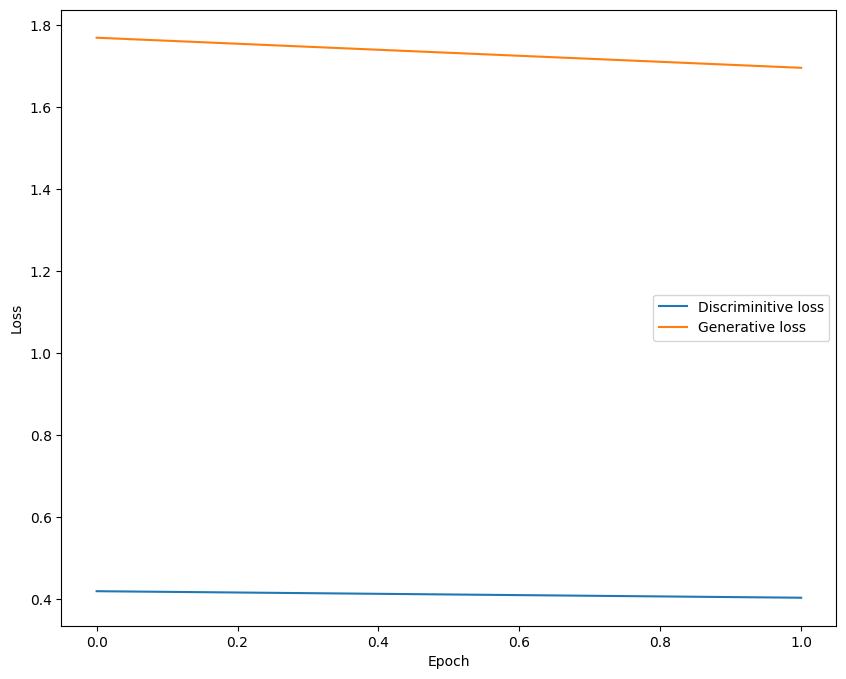

In [ ]:
# Define some training Parameters
# -------------------------------
Epochs = 2
BatchSize = 128
OutputFreq = 100


# Run the training with the selected parameters and model
# -------------------------------------------------------
train(Epochs, BatchSize, OutputFreq)

## Let's **evaluate visually** the quality reached by the Generator

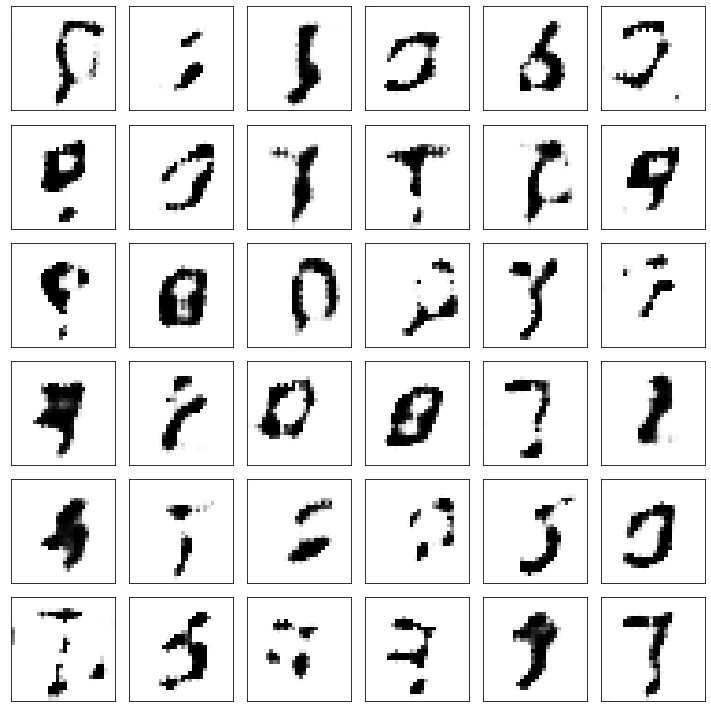

In [ ]:
plotGeneratedImages()


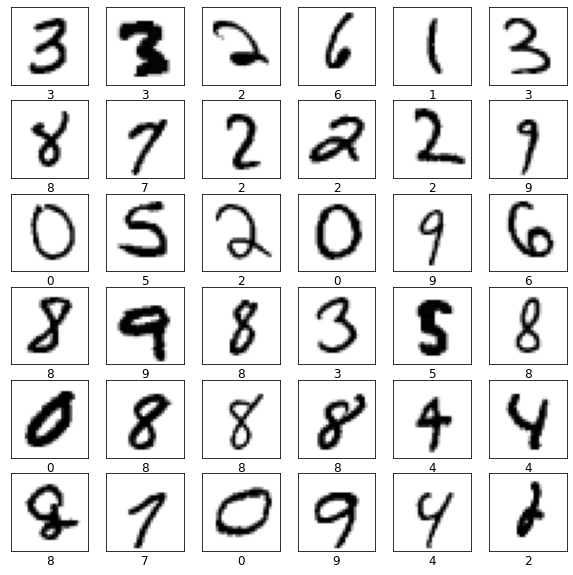

In [ ]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_train[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(y_train[image_ind], fontsize=12)

In [ ]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # Define the first convolutional layer
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu),

        # Define the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        # Define the second convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),

        # Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # Define the last Dense layer to output the classification
        # probabilities. Pay attention to the activation needed to get a probability in output
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    return cnn_model

cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(X_train[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 36)        7812      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               115328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [ ]:
'''Define the compile operation with your optimizer and learning rate of choice'''
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 5

'''Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.'''
cnn_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)


Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0155 - accuracy: 0.9950
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0129 - accuracy: 0.9959
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0109 - accuracy: 0.9963
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0089 - accuracy: 0.9970
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0091 - accuracy: 0.9969


In [ ]:
'''Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 36.0069 - accuracy: 0.9357
Test accuracy: 0.935699999332428


In [ ]:
predictions = cnn_model.predict(X_test)

In [ ]:
predictions[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
'''identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = np.argmax(predictions[0])

print(prediction)

7


Label of this digit is: 7


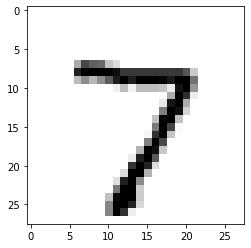

In [ ]:
print("Label of this digit is:", y_test[0])
plt.imshow(X_test[0,:,:,0], cmap=plt.cm.binary)

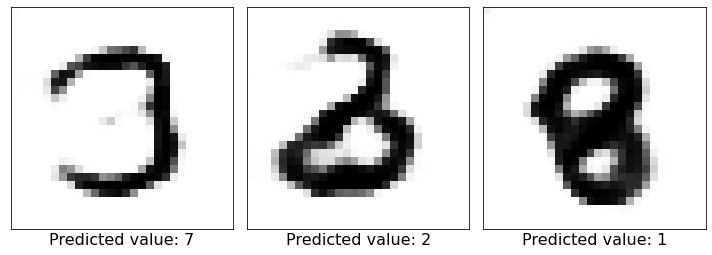

In [ ]:
examples = 3

noise = np.random.normal(0, 1, size=[examples, randomDim])
generatedImages = generator.predict(noise)

predictions = cnn_model.predict(X_test)

plt.figure(figsize=(10,10))
for i in range(generatedImages.shape[0]):
    plt.subplot(1, 3, i+1)
    plt.imshow(generatedImages[i, :,:, 0], interpolation='nearest', cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    prediction = np.argmax(predictions[i])

    plt.xlabel("Predicted value: {}".format(prediction), fontsize=16)
plt.tight_layout()
plt.show()
